# GAN creation

In [1]:
# For COLAB
# from google.colab import drive
# drive.mount('/content/gdrive')
# !pip install -q kaggle
# !mkdir ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json
# ! kaggle datasets download xhlulu/140k-real-and-fake-faces
# ! unzip /content/140k-real-and-fake-faces.zip

Streaming output truncated to the last 5000 lines.
  inflating: real_vs_fake/real-vs-fake/valid/real/34832.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34836.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34839.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34847.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34848.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34852.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34861.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34864.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34868.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34877.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34883.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34887.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34891.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34894.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34904.jpg  
  inflating: real_v

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import os

In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15021658043311514643
xla_global_id: -1
]


In [4]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

## Dataset loading

In [5]:
train = pd.read_csv("/content/real_vs_fake/train.csv")
valid = pd.read_csv("/content/real_vs_fake/valid.csv")
test  = pd.read_csv("/content/real_vs_fake/test.csv")

Reducing the data

In [6]:
def random_n_images(df,no_imgs=10000,shuffle=False):
    # each_label_images = int(no_imgs / 2)
    # subset_label_0 = df[df['label'] == 0].sample(n=each_label_images, random_state=69)
    subset_label_1 = df[df['label'] == 1].sample(n=no_imgs, random_state=69)
    if shuffle == True:
        subset_label_1 = subset_label_1.sample(frac=1, random_state=69).reset_index(drop=True)
    return subset_label_1

train_subset = random_n_images(train,no_imgs=10000,shuffle=True)
valid_subset = random_n_images(valid,no_imgs=2000,shuffle=False)
test_subset = random_n_images(test,no_imgs=2000,shuffle=False)

Converting to tensors

In [7]:
BATCH_SIZE = 32
image_height = 128
image_width = 128

In [8]:
train_tfds = tf.data.Dataset.from_tensor_slices((train_subset['path'].values,train_subset['label'].values))
valid_tfds = tf.data.Dataset.from_tensor_slices((valid_subset['path'].values,valid_subset['label'].values))
test_tfds = tf.data.Dataset.from_tensor_slices((test_subset['path'].values,test_subset['label'].values))

def read_image(image_file, label):
    image = tf.io.read_file("real_vs_fake/real-vs-fake/" + image_file)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [image_width,image_height])
    # image.set_shape((image_width, image_height, 3))
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

def augument(image, label):
    return image, label

train_tfds = train_tfds.map(read_image).map(augument).batch(BATCH_SIZE)
valid_tfds = valid_tfds.map(read_image).map(augument).batch(1).prefetch(1)
test_tfds = test_tfds.map(read_image).map(augument).batch(1)

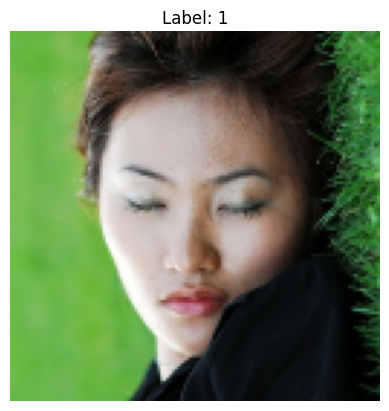

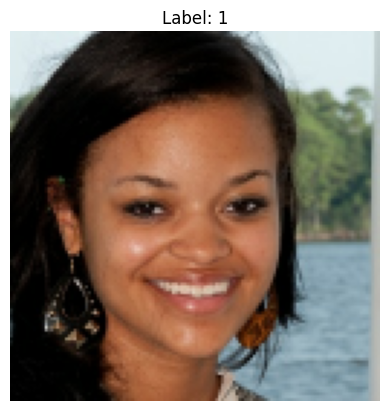

In [9]:
for images, labels in train_tfds.take(1):  # Adjust the number of batches as needed
    for i in range(2):
        # plt.figure(figsize=(4, 4))
        plt.imshow(images[i, :, :, :].numpy())
        plt.title(f"Label: {labels[i].numpy()}")
        plt.axis('off')
        plt.show()

## GAN architecture

In [10]:
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D, ReLU

In [27]:
def build_generator():
    model = Sequential()

    # Beginnings of a generated image
    model.add(Dense(4*4*1024, input_dim=256))
    model.add(LeakyReLU(0.2))
    model.add(Reshape((4,4,1024)))

    # Upsampling block
    model.add(UpSampling2D())
    model.add(Conv2D(512, (3,3), padding='same'))
    model.add(LeakyReLU(0.2))

    # Upsampling block
    model.add(UpSampling2D())
    model.add(Conv2D(256, (5,5), padding='same'))
    model.add(LeakyReLU(0.2))

    # Upsampling block
    model.add(UpSampling2D())
    model.add(Conv2D(128, (5,5), padding='same'))
    model.add(LeakyReLU(0.2))

    # Upsampling block
    model.add(UpSampling2D())
    model.add(Conv2D(64, (5,5), padding='same'))
    model.add(LeakyReLU(0.2))

    # Upsampling block
    model.add(UpSampling2D())
    model.add(Conv2D(3, (5,5), padding='same', activation='tanh'))

    # Conv layer to get to one channel
    # model.add(Conv2D(1, 4, padding='same', activation='sigmoid'))

    return model

generator = build_generator()
generator.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 16384)             4210688   
                                                                 
 leaky_re_lu_34 (LeakyReLU)  (None, 16384)             0         
                                                                 
 reshape_5 (Reshape)         (None, 4, 4, 1024)        0         
                                                                 
 up_sampling2d_25 (UpSampli  (None, 8, 8, 1024)        0         
 ng2D)                                                           
                                                                 
 conv2d_33 (Conv2D)          (None, 8, 8, 512)         4719104   
                                                                 
 leaky_re_lu_35 (LeakyReLU)  (None, 8, 8, 512)         0         
                                                      

1/1 [==============================] - 1s 1s/step


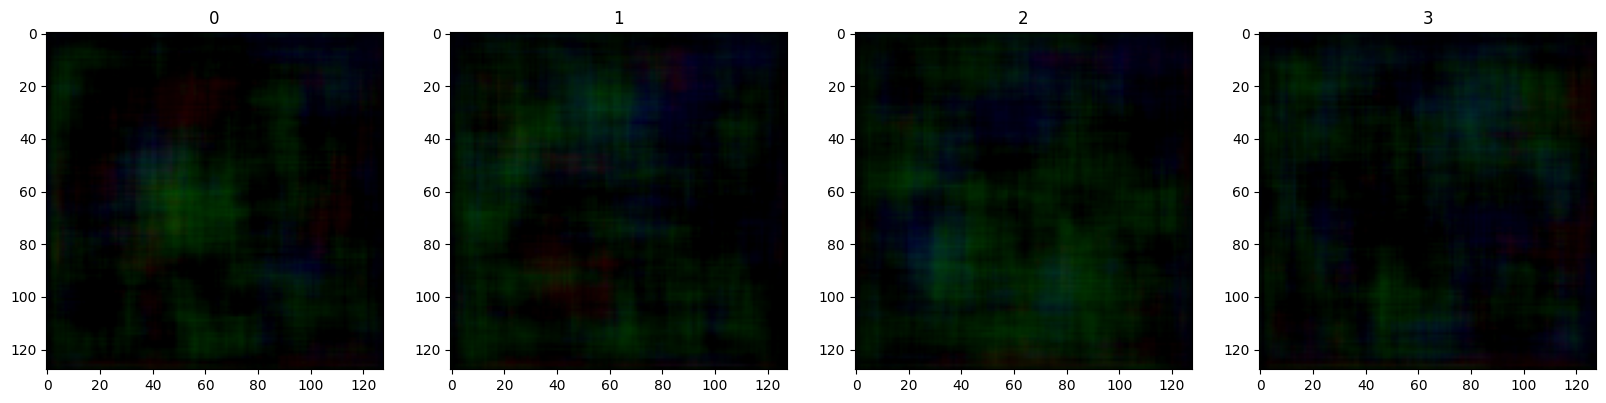

In [14]:
img = generator.predict(np.random.randn(4,256,1))

# Setup the subplot formatting
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
# Loop four times and get images
for idx, img in enumerate(img):
    # Plot the image using a specific subplot
    ax[idx].imshow(np.squeeze(img))
    # Appending the image label as the plot title
    ax[idx].title.set_text(idx)

In [31]:
def build_discriminator():
    model = Sequential()

    model.add(Conv2D(64, 5, 2, padding='same', input_shape = (image_width,image_height,3)))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    model.add(Conv2D(128, 5, 2, padding='same'))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    model.add(Conv2D(256, 5, 2, padding='same'))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    model.add(Conv2D(512, 5, 2, padding='same'))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    model.add(Conv2D(1024, 5, 2, padding='same'))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    # Flatten then pass to dense layer
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))

    return model

discriminator = build_discriminator()
discriminator.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_53 (Conv2D)          (None, 64, 64, 64)        4864      
                                                                 
 leaky_re_lu_54 (LeakyReLU)  (None, 64, 64, 64)        0         
                                                                 
 dropout_28 (Dropout)        (None, 64, 64, 64)        0         
                                                                 
 conv2d_54 (Conv2D)          (None, 32, 32, 128)       204928    
                                                                 
 leaky_re_lu_55 (LeakyReLU)  (None, 32, 32, 128)       0         
                                                                 
 dropout_29 (Dropout)        (None, 32, 32, 128)       0         
                                                                 
 conv2d_55 (Conv2D)          (None, 16, 16, 256)     

In [32]:
img = generator.predict(np.random.randn(4,256,1))

1/1 [==============================] - 1s 559ms/step


In [33]:
discriminator.predict(img)

1/1 [==============================] - 0s 216ms/step


array([[0.49973923],
       [0.49976364],
       [0.49972045],
       [0.5000584 ]], dtype=float32)

## Training loop

In [12]:
from keras.models import Model
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy
from keras.preprocessing.image import array_to_img
from keras.callbacks import Callback

In [ ]:
g_opt = Adam(learning_rate=0.0001)
d_opt = Adam(learning_rate=0.00001)
g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()

In [ ]:
class GAN(Model):
    def __init__(self, generator, discriminator, *args, **kwargs):
        # Pass through args and kwargs to base class
        super().__init__(*args, **kwargs)

        # Create attributes for gen and disc
        self.generator = generator
        self.discriminator = discriminator

    def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs):
        # Compile with base class
        super().compile(*args, **kwargs)

        # Create attributes for losses and optimizers
        self.g_opt = g_opt
        self.d_opt = d_opt
        self.g_loss = g_loss
        self.d_loss = d_loss

    def train_step(self, batch):
        # Get the data
        real_images = batch
        fake_images = self.generator(tf.random.normal((128, 128, 1)), training=False)

        # Train the discriminator
        with tf.GradientTape() as d_tape:
            # Pass the real and fake images to the discriminator model
            yhat_real = self.discriminator(real_images, training=True)
            yhat_fake = self.discriminator(fake_images, training=True)
            yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0)

            # Create labels for real and fakes images
            y_realfake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis=0)

            # Add some noise to the TRUE outputs
            noise_real = 0.15*tf.random.uniform(tf.shape(yhat_real))
            noise_fake = -0.15*tf.random.uniform(tf.shape(yhat_fake))
            y_realfake += tf.concat([noise_real, noise_fake], axis=0)

            # Calculate loss - BINARYCROSS
            total_d_loss = self.d_loss(y_realfake, yhat_realfake)

        # Apply backpropagation - nn learn
        dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables)
        self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))

        # Train the generator
        with tf.GradientTape() as g_tape:
            # Generate some new images
            gen_images = self.generator(tf.random.normal((128,128,1)), training=True)

            # Create the predicted labels
            predicted_labels = self.discriminator(gen_images, training=False)

            # Calculate loss - trick to training to fake out the discriminator
            total_g_loss = self.g_loss(tf.zeros_like(predicted_labels), predicted_labels)

        # Apply backprop
        ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
        self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))

        return {"d_loss":total_d_loss, "g_loss":total_g_loss}

In [ ]:
gan = GAN(generator, discriminator)
gan.compile(g_opt, d_opt, g_loss, d_loss)

In [ ]:
class ModelMonitor(Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.uniform((self.num_img, self.latent_dim,1))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = array_to_img(generated_images[i])
            img.save(os.path.join('images', f'generated_img_{epoch}_{i}.png'))

## Training

In [ ]:
hist = gan.fit(train_tfds, epochs=20, callbacks=[ModelMonitor()])

In [ ]:
plt.suptitle('Loss')
plt.plot(hist.history['d_loss'], label='d_loss')
plt.plot(hist.history['g_loss'], label='g_loss')
plt.legend()
plt.show()

In [ ]:
generator.save('/content/gdrive/MyDrive/GAN_research/generator.h5')
discriminator.save('/content/gdrive/MyDrive/GAN_research/discriminator.h5')

## Testing

In [ ]:
imgs = generator.predict(tf.random.normal((16, 128, 1)))
fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(10,10))
for r in range(4):
    for c in range(4):
        ax[r][c].imshow(imgs[(r+1)*(c+1)-1])